In [1]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import ip_tk

### Detecting suspicious activity using IP geolocation.

By collecting IP address location information from a public API, we were able to gather additional information about how users were accessing CodeUp's cirruculum.

In [3]:
# Use a helper utility to merge ip information into the dataframe
df = ip_tk.wrangle_ip_merged()

In [17]:
# Show off the kind of information collected
df[['user_id','ip','city','regionName','countryName','latitude','longitude']].sample(5, random_state = 8)

,user_id,ip,city,regionName,countryName,latitude,longitude
datetime,,,,,,,
2020-10-26 11:55:53,769,98.197.56.20,Houston,Texas,United States,29.7912,-95.4182
2019-01-15 11:06:19,267,97.105.19.58,Euless,Texas,United States,32.8548,-97.0819
2018-08-07 13:10:12,40,97.105.19.58,Euless,Texas,United States,32.8548,-97.0819
2021-02-14 12:39:19,788,173.175.108.125,San Antonio,Texas,United States,29.4551,-98.6498
2020-10-17 23:20:16,668,70.94.168.22,San Antonio,Texas,United States,29.4812,-98.3435


Now, because we have both a timestamp and location information associated with each log entry, we are able to see if anyone is moving around the world impossibly fast.

As an example of how we can use this information, we can ask if anyone was in multiple countries within the same hour.

In [18]:
# Get geohopping events by the hour
ip_tk.detect_country_geohop_events(df, window='1H', group_by='user_id')

,when_start,when_end,where,user_id
0,2020-02-15 00:00:00,2020-02-15 01:00:00,"[Mexico, United States]",64
1,2018-07-28 11:00:00,2018-07-28 12:00:00,"[United States, Canada]",128
2,2018-07-29 16:00:00,2018-07-29 17:00:00,"[United States, Canada]",128
3,2019-01-11 09:00:00,2019-01-11 10:00:00,"[Germany, United States]",270
4,2019-01-14 09:00:00,2019-01-14 10:00:00,"[United States, Germany]",270
5,2019-12-08 12:00:00,2019-12-08 13:00:00,"[Germany, Australia]",469
6,2019-12-12 10:00:00,2019-12-12 11:00:00,"[Australia, United States]",469
7,2019-12-16 10:00:00,2019-12-16 11:00:00,"[Canada, United States]",469
8,2020-01-03 21:00:00,2020-01-03 22:00:00,"[Canada, United States]",469
9,2020-04-16 16:00:00,2020-04-16 17:00:00,"[Switzerland, United States]",570


This is symptomatic evidence of leaked credentials.  It is also possible that some users used VPNs to tunnel their traffic from different countries, but these events should be taken seriously nonetheless.

An small window, such as a single hour, gives us very confident results.  It is very unlikely that any of these users could travel between these countries so quickly.  However, the small window means that we miss out on attacks that may have happened during off hours or weekends.  To compensate for that we can ask the same question with a larger window.

In [19]:
# Get geohopping events by the week
ip_tk.detect_country_geohop_events(df, window='1W', group_by='user_id')

,when_start,when_end,where,user_id
0,2018-04-01,2018-04-08,"[United States, Mexico]",3
1,2018-04-08,2018-04-15,"[United States, Mexico]",3
2,2018-04-01,2018-04-08,"[United States, Germany]",12
3,2020-02-02,2020-02-09,"[Canada, United States]",12
4,2018-04-22,2018-04-29,"[United States, Canada, France]",32
5,2018-03-11,2018-03-18,"[United States, Mexico]",64
6,2019-08-04,2019-08-11,"[United States, Mexico]",64
7,2019-12-01,2019-12-08,"[United States, Canada]",64
8,2019-12-22,2019-12-29,"[United States, Mexico]",64
9,2020-01-19,2020-01-26,"[United States, Mexico]",64


#### Takeaways
There is very strong evidence to suggest that some users may have compromised credentials.

## Confirming the access policy change in 2019

The data that we have access to does not include if a user is accessing a lesson that they are supposed to have access to.  In order to answer this question we will need to improvise.

An assumption can be made that a module belongs to the program where the users belonging to that program access it the most.  In order to tackle this question we will be making that assumption.

In [20]:
def build_module_parent_df(df):
    # Group by module and get the number of accesses for each program
    mod_prog = df.groupby('module').program.value_counts()
    # Flatten the result 
    a = mod_prog.rename('vcount').reset_index()
    out = {}
    for i, mod in enumerate(a.module.unique().tolist()):
        this = a[a.module == mod]
        out[i] = {'module':mod, 'module_parent':this.set_index('program').vcount.idxmax()}

    return pd.DataFrame.from_dict(out, orient='index')

In [44]:
parents = build_module_parent_df(df)
parents.sample(15, random_state=42)

,module,module_parent
286,8.05_Deliver,Full Stack Java
652,studentx,Full Stack Java
257,7-clustering,Full Stack Java
336,Classification_KNN,Full Stack Java
318,9_Appendix_TSAD_Lesson2,Full Stack Java
211,5.01_Acquire,Full Stack Java
621,sample-database,Full Stack Java
176,3.5.3-limit,Full Stack Java
576,mvc,Full Stack Java
256,7-classification,Data Science


However, if we take a critical look at the module/parent assignments we can determine that the assumption quickly falls apart.  As a student in the Data Science program, I know that modules such as Acquire, Prepare, Explore, and Model are all not supposed to be assigned to the Full Stack Java program.

In [45]:
# Show an example of erroneously classified modules.
selection = ['10.01_Acquire_WebScraping',
'10.3_Acquire',
'10.4_Prepare',
'10.5_Explore',
'10.6_Model',
'10._NLP',
'Index.html']

parents[parents.module.isin(selection)]

,module,module_parent
27,10.01_Acquire_WebScraping,Full Stack Java
40,10.3_Acquire,Full Stack Java
41,10.4_Prepare,Full Stack Java
42,10.5_Explore,Full Stack Java
43,10.6_Model,Full Stack Java
44,10._NLP,Full Stack Java
357,Index.html,Data Science


However, it is better than nothing. So we will try to use what we have and set ourselves up to be able to visualize the rate of unauthorized access logs.

In [46]:
# Set merge the module/parent data with the main dataframe, but store the result in a new variable to avoid conflicts with the rest of the notebook.
xf = df.reset_index().merge(parents, how='left', on='module').set_index('datetime')
# Get rid of any nulls for the purposes of 
xf = xf.dropna(subset=['module', 'module_parent', 'program_id'])

# Group the full stack programs together since we expect overlap.
xf.loc[xf.program.str.contains('Full Stack'), 'program'] = 'Full Stack'
xf.loc[xf.module_parent.str.contains('Full Stack'), 'module_parent'] = 'Full Stack'

# Create a new column that determines if this access record should have been able to access the page
xf['unauth_acc'] = xf.program != xf.module_parent

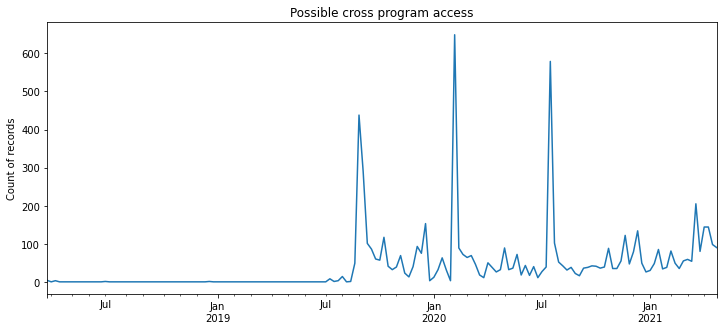

In [47]:
plt.figure(figsize=(12,5))
xf[xf.unauth_acc  & (xf.cohort_name != 'Staff')].unauth_acc.resample('W').sum().plot()
plt.title('Possible cross program access')
plt.ylabel('Count of records')
plt.xlabel(None)
plt.show()

### Takeaways:
While we don't have enough data to confirm the effectiveness of the policy change.  We can clearly see that there was a policy change that occured sometime around July 2019